# Shill Bidding Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
from scipy import stats
#from scipy.special import boxcox1p
#from scipy.stats import boxcox_normmax
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier
from sklearn.svm import SVC

#Common Model Helpers
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from matplotlib.colors import ListedColormap

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import optuna

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

seed = 42

In [2]:
shill = pd.read_csv('Shill_Bidding_Dataset.csv')
shill.head()

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


In [3]:
fraud_cases = shill[shill["Class"] == 1]
valid_cases = shill[shill["Class"] == 0]

Outlier_fraction=len(fraud_cases)/float(len(valid_cases))
print(Outlier_fraction)
print("fraud cases {}".format(len(fraud_cases)))
print("Valid cases {}".format(len(valid_cases)))

0.11955366631243358
fraud cases 675
Valid cases 5646


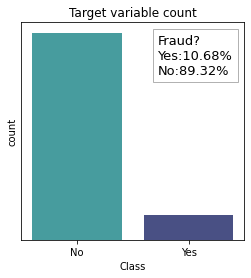

In [4]:
perc_1 = len(shill[shill['Class']==1])/len(shill)
perc_0 = len(shill[shill['Class']==0])/len(shill)

labels=['No','Yes']

plt.figure(figsize=(4,4))
ax = sns.countplot(x='Class', data=shill, palette='mako_r')
#ax.bar_label(ax.containers[0])
plt.title('Target variable count')
plt.yticks([])
plt.figtext(.6, .7, "Fraud?\nYes:{:.2f}%\nNo:{:.2f}%".format(perc_1*100,perc_0*100), bbox ={'facecolor':'white', 
                   'alpha':0.3, 'pad':5}, fontsize=13)
plt.xticks(shill['Class'].value_counts().index, labels)
plt.show()

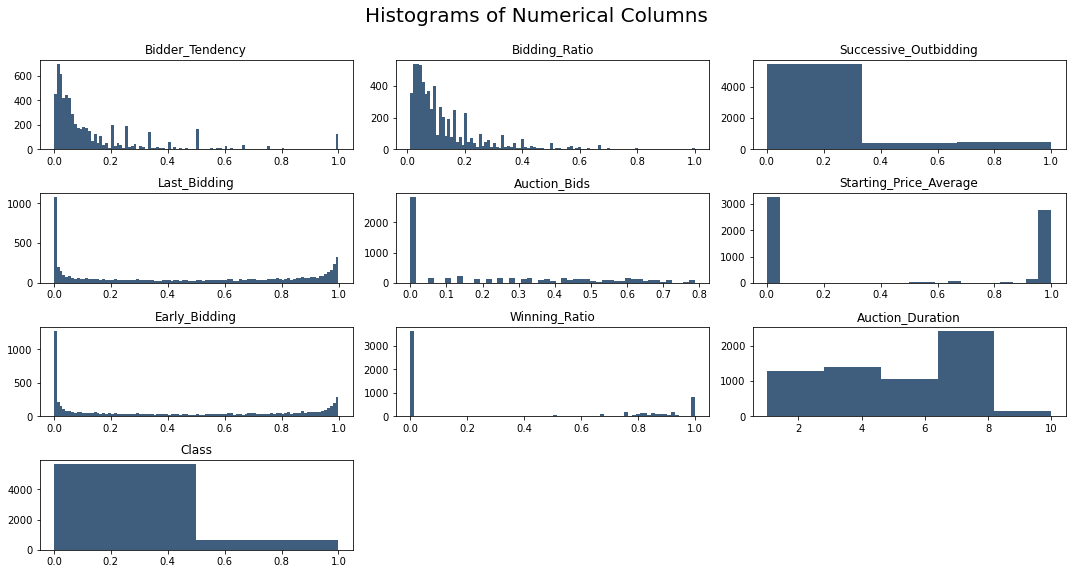

In [5]:
shill3 = shill.copy().drop(columns = ['Auction_ID','Bidder_ID','Record_ID']) 

fig = plt.figure(figsize=(15,12))

plt.suptitle('Histograms of Numerical Columns', fontsize = 20)
#Since we want to plot every feature in one single plot, we re going to iterate every feature

for i in range(shill3.shape[1]):
    #This will iterate every feature.Shape gives the dimensions of the dataframe and he first item gives the number of columns
    #and since python does not include all the columns we are adding 1 to it. 
    plt.subplot(6,3,i+1)
    #Here in subplot, we are going to tell python number of images in the plot.'i' is given to tell what we are 
    #working on the moment
    f = plt.gca()
    #gca() command cleans up everything
    f.set_title(shill3.columns.values[i])
    #It will title each feature
    
    vals = np.size(shill3.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    #It will tell python how many bins will be in each feature. [:, i-1 ] will query the entire column
    
    plt.hist(shill3.iloc[:, i], bins = vals, color= '#3F5D7D')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

**HISTOGRAM**

BIDDER TENDENCY: From the histogram we see that most of the people have the value of 0 - 0.2. Between 0.2 - 0.4, we see the next cluster of Bids.

Bidding Ratio : The histogram implies that the majority of people are in the Bidding Ratio of 0 - 0.2 which means in most cases, there is no bidding ratio.

Successive Outbidding: There is a high percentage of people in the 0 category and very less people in the in 1 category which implies that most records show that they do not indulge in successive outbidding.

Last Bidding: A Shill Bidder becomes inactive at the last stage. There is not an evidence of Last Bidding but in the end, the data shows a spike in the number of people in last bidding.

Auction Duration : The data shows that the auction duration is mainly between 1 - 6 for most number of biddings and between 6-8, the number of bidding is the highest.

Class: The histogram suggest in most of the bidding cases(6000), the data is 0 which implies the shill bidding did not take place while the answer is 1 for around less than 1000 cases.

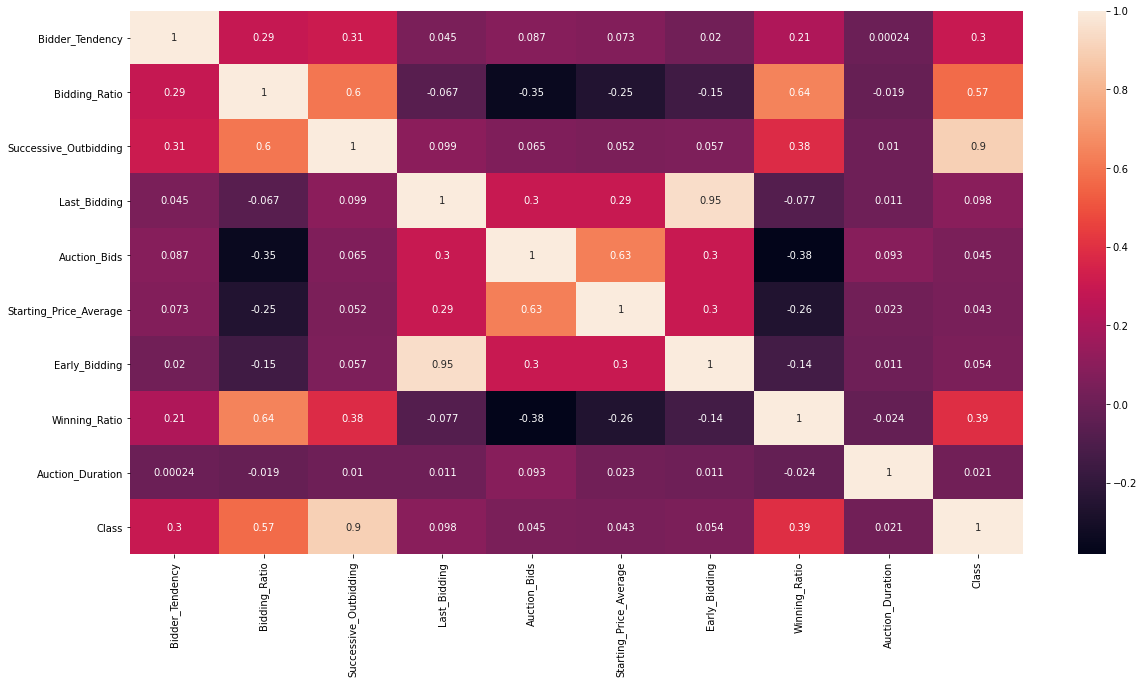

In [6]:
plt.figure(figsize = (20,10))
sns.heatmap(shill3.corr(), annot = True)

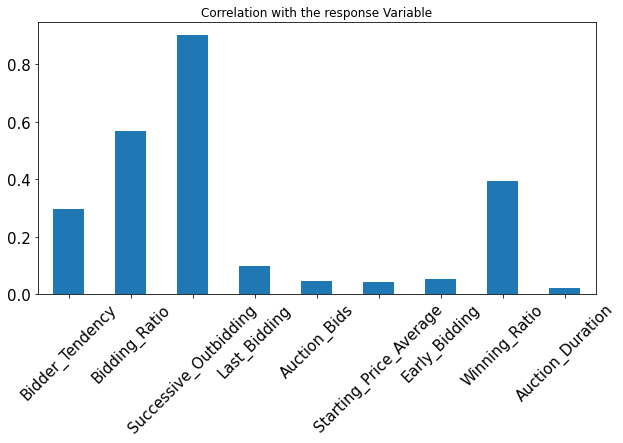

In [8]:
shill2 = shill.copy().drop(columns = ['Class','Auction_ID','Bidder_ID','Record_ID'])

shill2.corrwith(shill.Class).plot.bar(figsize = (10,5), title = 'Correlation with the response Variable', fontsize = 15, rot= 45)

**Cor-relation Plot**
Successive Outbidding: A shill bidder successively outbids himself even though he is the current winner to increase the price gradually with small consecutive increments.

The co-relation plot for Successive Outbidding and response variable is highest. It suggests that if there is successive outbidding, then the co-relation of outbidding is the highest.

Bidding Tendency, Bidding Ratio, Winning Ratio also have high correlation which show that if their value is high, so is the probability of the Bidder indulging in Shill Bidding.

The correlation of Last Bidding, Auction Bids, Starting Price Average, Early Bidding and Auction Duration has a very low corelation with the response variable. It suggests that these variables have very less infleunce on the response variable.

Positive Correlation:

Bidder Tendency and Bidding Ratio, Successive Outbidding, Winning Ratio have high correlation.

Successive Outbidding and Winning ratio have high correlation.

Last Bidding and Starting Price Average, Early Bidding, and Auction Bids have positive correlation.

Negative Correlation:

Bidding Ratio and Auction Bids, Starting Price Average, Early Bidding have negative correlation

Auction Bids and Winning Ratio have negative corelation.

Starting Price Average and Winning Ratio have negative correlation

**Data Split**

In [9]:
X = shill.drop(columns=['Class', 'Record_ID', 'Auction_ID', 'Bidder_ID'])
y = shill.Class
X

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration
0,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5
1,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5
2,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5
3,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5
4,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7
...,...,...,...,...,...,...,...,...,...
6316,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3
6317,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7
6318,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7
6319,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7


In [10]:
y.value_counts()

0    5646
1     675
Name: Class, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

print(f"Training set: {X_train.shape[0]}")
print(f"Validation set: {X_val.shape[0]}")
print(f"Test set: {X_test.shape[0]}")

Training set: 4044
Validation set: 1012
Test set: 1265


In [12]:
y_train.value_counts()

0    3612
1     432
Name: Class, dtype: int64

In [13]:
shill[shill.duplicated()].shape

(0, 13)

So, there is no duplicate in this dataset

In [14]:
shill.columns

Index(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Bidder_Tendency',
       'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding',
       'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding',
       'Winning_Ratio', 'Auction_Duration', 'Class'],
      dtype='object')

In [15]:
shill.isna().any()

Record_ID                 False
Auction_ID                False
Bidder_ID                 False
Bidder_Tendency           False
Bidding_Ratio             False
Successive_Outbidding     False
Last_Bidding              False
Auction_Bids              False
Starting_Price_Average    False
Early_Bidding             False
Winning_Ratio             False
Auction_Duration          False
Class                     False
dtype: bool

# Applying PCA

In [16]:
X_scaled = scaler.fit_transform(X)

In [17]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_scaled);

In [18]:
cum_sum = np.cumsum(pca.explained_variance_ratio_)*100
comp= [n for n in range(len(cum_sum))]

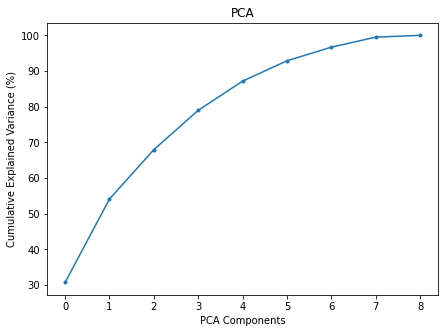

In [19]:
plt.figure(figsize=(7,5))
plt.plot(comp, cum_sum, marker='.')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA')
plt.show()

# Class balance by Undersampling

When undersampling, we aim to remove a number of the rows of the majority class (rows where class=0) in order to match the number of rows of the minority class (rows where class=1).

In [20]:
y_train.value_counts()

0    3612
1     432
Name: Class, dtype: int64

In [21]:
rus = RandomUnderSampler(random_state=seed)

In [22]:
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [23]:
y_train_us.value_counts()

1    432
0    432
Name: Class, dtype: int64

In [24]:
X_train_us, X_val_us, y_train_us, y_val_us = train_test_split(X_train_us, y_train_us, test_size=0.2, random_state = seed)

# Class balance by oversampling with SMOTE

Now, oversampling will be performed on the training data.

In [25]:
y_train.value_counts()

0    3612
1     432
Name: Class, dtype: int64

This means that we will add 3612 - 432 = 3180 rows with 'Class' = 1, which is indeed a large number of duplicates that will be added.

In [26]:
smote = SMOTE(random_state=seed)

X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

y_train_os.value_counts()

1    3612
0    3612
Name: Class, dtype: int64

The training data is now balanced.

In [27]:
X_train_os, X_val_os, y_train_os, y_val_os = train_test_split(X_train_os, y_train_os, stratify=y_train_os, test_size=0.2, random_state = seed)

# Hybrid Sampling Method

A combination of under- and oversampling method using pipeline

In [28]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
from matplotlib import pyplot

In [29]:
# define pipeline
over = SMOTE(sampling_strategy = "not minority")
under = RandomUnderSampler(sampling_strategy = "majority")
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_h, y_h = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_h)
print(counter)

Counter({0: 675, 1: 675})


In [30]:
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.2, stratify = y_h, random_state=seed)

scaler = StandardScaler()

X_train_h = scaler.fit_transform(X_train_h)
X_test_h = scaler.transform(X_test_h)

X_train_h, X_val_h, y_train_h, y_val_h = train_test_split(X_train_h, y_train_h, test_size=0.2, stratify=y_train_h, random_state=seed)

print(f"Training set: {X_train_h.shape[0]}")
print(f"Validation set: {X_val_h.shape[0]}")
print(f"Test set: {X_test_h.shape[0]}")

Training set: 864
Validation set: 216
Test set: 270


# Logistic Regression

## Imbalanced Dataset

In [161]:
LogReg = LogisticRegression()
LogReg.fit(X_train,y_train)

print('Accuracy on whole data : ' + str(LogReg.score(X, y)))
print('Accuracy on training data : ' + str(LogReg.score(X_train, y_train)))
print('Accuracy on testing data : ' + str(LogReg.score(X_test, y_test)))

Accuracy on whole data : 0.8955861414333175
Accuracy on training data : 0.9750247279920871
Accuracy on testing data : 0.9786561264822135


In [162]:
def evaluate(y, y_hat):
        y = (y == 1)
        
        y_hat = (y_hat == 1)
        
        accuracy = (y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        
        return accuracy, recall, precision

In [163]:
y_hat = LogReg.predict(X_train)
log_train_acc, log_train_rec, log_train_pres = evaluate(y_train, y_hat)
print('Logistic regression accuracy on train data  :  ' + str(log_train_acc))
print('Logistic regression recall on train data  :  ' + str(log_train_rec))
print('Logistic regression precision on train data  :  ' + str(log_train_pres))

Logistic regression accuracy on train data  :  0.9750247279920871
Logistic regression recall on train data  :  0.8958333333333334
Logistic regression precision on train data  :  0.873589164785553


In [164]:
y_p = LogReg.predict(X)
log_train_acc, log_train_rec, log_train_pres = evaluate(y, y_p)
print('Logistic regression accuracy on data  :  ' + str(log_train_acc))
print('Logistic regression recall on data  :  ' + str(log_train_rec))
print('Logistic regression precision on data  :  ' + str(log_train_pres))

Logistic regression accuracy on data  :  0.8955861414333175
Logistic regression recall on data  :  0.02962962962962963
Logistic regression precision on data  :  0.8


In [165]:
y_pred_LRi = LogReg.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.91      0.66      0.76      5646
         Yes       0.14      0.45      0.21       675

    accuracy                           0.63      6321
   macro avg       0.52      0.55      0.48      6321
weighted avg       0.83      0.63      0.70      6321



We can see a good precision score of 0.80 and a very low recall 0.03 for Target = 1.

Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. But we achieved lower recall value for logistic regression model. Which means it has higher false negative.

By using this model, most of the users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [36]:
LogReg.fit(X_train_us,y_train_us)

y_pred = LogReg.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.94      1.00      0.97      5646
         Yes       0.98      0.49      0.65       675

    accuracy                           0.94      6321
   macro avg       0.96      0.74      0.81      6321
weighted avg       0.95      0.94      0.94      6321



## Oversampling

In [46]:
LogReg.fit(X_train_os,y_train_os)

y_pred = LogReg.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.98      5646
         Yes       0.98      0.75      0.85       675

    accuracy                           0.97      6321
   macro avg       0.98      0.88      0.92      6321
weighted avg       0.97      0.97      0.97      6321



## Hybrid Sampling

In [55]:
#import warnings
#warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

LogReg.fit(X_train_h,y_train_h)

y_pred = LogReg.predict(X_test).round()
print(classification_report(y_test, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.71      0.83      1130
         Yes       0.29      1.00      0.45       135

    accuracy                           0.74      1265
   macro avg       0.65      0.86      0.64      1265
weighted avg       0.92      0.74      0.79      1265



# SVM

## Imbalanced Dataset

In [56]:
SVM = SVC(C=10).fit(X_train, y_train)
print('RBF-kernel SVC (with Standard scaling) training set accuracy: {:.2f}'
     .format(SVM.score(X_train, y_train)))
print('RBF-kernel SVC (with Standard scaling) test set accuracy: {:.2f}'
     .format(SVM.score(X_test, y_test)))

RBF-kernel SVC (with Standard scaling) training set accuracy: 1.00
RBF-kernel SVC (with Standard scaling) test set accuracy: 0.99


In [57]:
y_pred = SVM.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.92      0.96      0.94      5646
         Yes       0.48      0.30      0.37       675

    accuracy                           0.89      6321
   macro avg       0.70      0.63      0.65      6321
weighted avg       0.87      0.89      0.88      6321



We can see a precision score of 0.48 and lower recall 0.30 for Target = 1.

Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. But we achieved lower recall and precision value for Support Vector Machine model.

By using this model, most of the users would see their *valid* activity labeled as *fraudolent*. And a good number of *Fraud* will be labeled *valid*.

## Undersampling

In [58]:
SVM = SVC(C=10).fit(X_train_us, y_train_us)
print('RBF-kernel SVC (with Standard scaling) training set accuracy: {:.2f}'
     .format(SVM.score(X_train_us, y_train_us)))
print('RBF-kernel SVC (with Standard scaling) test set accuracy: {:.2f}'
     .format(SVM.score(X_val_us, y_val_us)))

RBF-kernel SVC (with Standard scaling) training set accuracy: 1.00
RBF-kernel SVC (with Standard scaling) test set accuracy: 0.98


In [59]:
y_pred = SVM.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.98      0.34      0.51      5646
         Yes       0.14      0.93      0.25       675

    accuracy                           0.40      6321
   macro avg       0.56      0.64      0.38      6321
weighted avg       0.89      0.40      0.48      6321



## Oversampling

In [60]:
SVM = SVC(C=10).fit(X_train_os, y_train_os)
print('RBF-kernel SVC (with Standard scaling) training set accuracy: {:.2f}'
     .format(SVM.score(X_train_os, y_train_os)))
print('RBF-kernel SVC (with Standard scaling) test set accuracy: {:.2f}'
     .format(SVM.score(X_val_os, y_val_os)))

RBF-kernel SVC (with Standard scaling) training set accuracy: 1.00
RBF-kernel SVC (with Standard scaling) test set accuracy: 1.00


In [61]:
y_pred = SVM.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.92      0.87      0.89      5646
         Yes       0.24      0.34      0.28       675

    accuracy                           0.82      6321
   macro avg       0.58      0.61      0.59      6321
weighted avg       0.85      0.82      0.83      6321



## Hybrid sampling

In [62]:
SVM = SVC(C=10).fit(X_train_h, y_train_h)
print('RBF-kernel SVC (with Standard scaling) training set accuracy: {:.2f}'
     .format(SVM.score(X_train_h, y_train_h)))
print('RBF-kernel SVC (with Standard scaling) test set accuracy: {:.2f}'
     .format(SVM.score(X_val_h, y_val_h)))

RBF-kernel SVC (with Standard scaling) training set accuracy: 1.00
RBF-kernel SVC (with Standard scaling) test set accuracy: 1.00


In [63]:
y_pred = SVM.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.89      0.57      0.69      5646
         Yes       0.11      0.42      0.17       675

    accuracy                           0.55      6321
   macro avg       0.50      0.50      0.43      6321
weighted avg       0.81      0.55      0.64      6321



# Decision Tree Classifier

## Imbalanced Dataset

In [64]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 10,
                            random_state = seed).fit(X_train, y_train)

print('Accuracy of DT classifier on training set: {:.2f}'
     .format(DTC.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(DTC.score(X_test, y_test)))

Accuracy of DT classifier on training set: 1.00
Accuracy of DT classifier on test set: 1.00


In [65]:
y_pred = DTC.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.96      1.00      0.98      5646
         Yes       0.96      0.67      0.79       675

    accuracy                           0.96      6321
   macro avg       0.96      0.83      0.88      6321
weighted avg       0.96      0.96      0.96      6321



We can see a precision score of 0.96 and recall score of 0.67 for Target = 1.

Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved lower recall value for Decision Tree Classifier Algorithm.

By using this model, most of the users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [66]:
DTC = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 10,
                            random_state = seed).fit(X_train_us, y_train_us)

print('Accuracy of DT classifier on training set: {:.2f}'
     .format(DTC.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(DTC.score(X_test, y_test)))

Accuracy of DT classifier on training set: 0.97
Accuracy of DT classifier on test set: 0.97


In [67]:
y_pred = DTC.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.96      1.00      0.98      5646
         Yes       0.96      0.67      0.79       675

    accuracy                           0.96      6321
   macro avg       0.96      0.83      0.88      6321
weighted avg       0.96      0.96      0.96      6321



## Oversampling

In [68]:
DTC = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 10,
                            random_state = seed).fit(X_train_os, y_train_os)

print('Accuracy of DT classifier on training set: {:.2f}'
     .format(DTC.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(DTC.score(X_test, y_test)))

Accuracy of DT classifier on training set: 1.00
Accuracy of DT classifier on test set: 0.99


In [69]:
y_pred = DTC.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.00      0.00      0.00      5646
         Yes       0.11      1.00      0.19       675

    accuracy                           0.11      6321
   macro avg       0.05      0.50      0.10      6321
weighted avg       0.01      0.11      0.02      6321



## Hybrid sampling

In [70]:
DTC = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 10,
                            random_state = seed).fit(X_train_h, y_train_h )

print('Accuracy of DT classifier on training set: {:.2f}'
     .format(DTC.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(DTC.score(X_test, y_test)))

Accuracy of DT classifier on training set: 0.40
Accuracy of DT classifier on test set: 0.41


In [72]:
y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.34      0.50      1130
         Yes       0.15      1.00      0.26       135

    accuracy                           0.41      1265
   macro avg       0.58      0.67      0.38      1265
weighted avg       0.91      0.41      0.48      1265



# Naive Bayes

## Imbalanced Dataset

In [73]:
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train, y_train)

print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.97
Accuracy of GaussianNB classifier on test set: 0.97


In [74]:
y_pred = nbclf.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.96      1.00      0.98      5646
         Yes       0.99      0.67      0.79       675

    accuracy                           0.96      6321
   macro avg       0.97      0.83      0.89      6321
weighted avg       0.96      0.96      0.96      6321



We can see a precision score of 0.99 and recall score of 0.67 for Target = 1.

Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved lower recall value for Naive Bayes Classifier Algorithm.

By using this model, many users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [75]:
nbclf = GaussianNB().fit(X_train_us, y_train_us)

print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.97
Accuracy of GaussianNB classifier on test set: 0.97


In [76]:
y_pred = nbclf.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.96      1.00      0.98      5646
         Yes       0.98      0.67      0.80       675

    accuracy                           0.96      6321
   macro avg       0.97      0.83      0.89      6321
weighted avg       0.96      0.96      0.96      6321



## Oversampling

In [77]:
nbclf = GaussianNB().fit(X_train_os, y_train_os)

print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.97
Accuracy of GaussianNB classifier on test set: 0.97


In [78]:
y_pred = nbclf.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.96      1.00      0.98      5646
         Yes       0.98      0.67      0.79       675

    accuracy                           0.96      6321
   macro avg       0.97      0.83      0.89      6321
weighted avg       0.96      0.96      0.96      6321



## Hybrid sampling

In [79]:
nbclf = GaussianNB().fit(X_train_h, y_train_h)

print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.74
Accuracy of GaussianNB classifier on test set: 0.75


In [80]:
y_pred = nbclf.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.01      0.01      5646
         Yes       0.11      1.00      0.19       675

    accuracy                           0.11      6321
   macro avg       0.55      0.50      0.10      6321
weighted avg       0.90      0.11      0.03      6321



# Random Forest

## Imbalanced Dataset

In [81]:
from sklearn.ensemble import RandomForestClassifier


Rfclf = RandomForestClassifier(max_features = 8, random_state = 0).fit(X_train, y_train)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 1.00


In [82]:
y_pred = Rfclf.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.91      1.00      0.95      5646
         Yes       1.00      0.14      0.24       675

    accuracy                           0.91      6321
   macro avg       0.95      0.57      0.60      6321
weighted avg       0.92      0.91      0.87      6321



We can see a precision score of 1.0 and lower recall score of 0.14 for Target = 1.

Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved lower recall value for Random Forest Classifier Algorithm.

By using this model, a large number of users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [83]:
Rfclf = RandomForestClassifier(max_features = 8, random_state = 0).fit(X_train_us, y_train_us)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.98
Accuracy of RF classifier on test set: 0.98


In [84]:
y_pred = Rfclf.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.96      1.00      0.98      5646
         Yes       0.96      0.67      0.79       675

    accuracy                           0.96      6321
   macro avg       0.96      0.83      0.88      6321
weighted avg       0.96      0.96      0.96      6321



## Oversampling

In [85]:
Rfclf = RandomForestClassifier(max_features = 8, random_state = 0).fit(X_train_os, y_train_os)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 1.00


In [86]:
y_pred = Rfclf.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.90      0.88      0.89      5646
         Yes       0.18      0.23      0.20       675

    accuracy                           0.81      6321
   macro avg       0.54      0.55      0.55      6321
weighted avg       0.83      0.81      0.82      6321



## Hybrid Sampling

In [87]:
Rfclf = RandomForestClassifier(max_features = 8, random_state = 0).fit(X_train_h, y_train_h)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.59
Accuracy of RF classifier on test set: 0.60


In [88]:
y_pred = Rfclf.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.90      0.80      0.84      5646
         Yes       0.12      0.23      0.16       675

    accuracy                           0.74      6321
   macro avg       0.51      0.51      0.50      6321
weighted avg       0.81      0.74      0.77      6321



# KNN

## Imbalanced Dataset

In [89]:
from sklearn.neighbors import KNeighborsClassifier  

knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ).fit(X_train, y_train)
print('Accuracy of Knn classifier on training set: {:.2f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of Knn classifier on test set: {:.2f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of Knn classifier on training set: 0.59
Accuracy of Knn classifier on test set: 0.60


In [90]:
y_pred = knn.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.91      1.00      0.95      5646
         Yes       1.00      0.16      0.28       675

    accuracy                           0.91      6321
   macro avg       0.95      0.58      0.62      6321
weighted avg       0.92      0.91      0.88      6321



We can see a precision score of 1.0 and lower recall score of 0.16 for Target = 1.

Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved lower recall value for Random Forest Classifier Algorithm.

By using this model, a large number of users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [91]:
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ).fit(X_train_us, y_train_us)
print('Accuracy of Knn classifier on training set: {:.2f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of Knn classifier on test set: {:.2f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of Knn classifier on training set: 0.59
Accuracy of Knn classifier on test set: 0.60


In [92]:
y_pred = knn.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.93      0.97      0.95      5646
         Yes       0.63      0.41      0.50       675

    accuracy                           0.91      6321
   macro avg       0.78      0.69      0.72      6321
weighted avg       0.90      0.91      0.90      6321



## Oversampling

In [93]:
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ).fit(X_train_os, y_train_os)
print('Accuracy of Knn classifier on training set: {:.2f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of Knn classifier on test set: {:.2f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of Knn classifier on training set: 0.59
Accuracy of Knn classifier on test set: 0.60


In [94]:
y_pred = knn.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.92      1.00      0.96      5646
         Yes       0.97      0.31      0.46       675

    accuracy                           0.92      6321
   macro avg       0.95      0.65      0.71      6321
weighted avg       0.93      0.92      0.91      6321



## Hybrid sampling

In [95]:
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ).fit(X_train_h, y_train_h)
print('Accuracy of Knn classifier on training set: {:.2f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of Knn classifier on test set: {:.2f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of Knn classifier on training set: 0.59
Accuracy of Knn classifier on test set: 0.60


In [96]:
y_pred = knn.predict(X)
print(classification_report(y, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.91      0.66      0.76      5646
         Yes       0.14      0.45      0.21       675

    accuracy                           0.63      6321
   macro avg       0.52      0.55      0.48      6321
weighted avg       0.83      0.63      0.70      6321



# Applying Neural Network

## Imbalanced Dataset

In [97]:
EPOCHS = 100
BATCH_SIZE = 256
def objective(trial):

    model = keras.Sequential()

    in_feat = X_train.shape[0]

    for i in range(trial.suggest_int("n_layers", 1, 2)):
        out_feat = trial.suggest_int("n_units_{}".format(i+1), 1, 40)
        model.add(keras.layers.Dense(units=out_feat, activation='relu'))
        model.add(keras.layers.Dropout(trial.suggest_uniform("dropout_{}".format(i+1), 0.2, 0.5)))
        in_feat=out_feat
 
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(trial.suggest_float("lr", 5e-5, 1e-2, log=True)),
                  metrics=['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    
    model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
              verbose = False )
    
    score = model.evaluate(X_val, y_val, verbose=0)
                  
    return score[1]

In [98]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

params_1 = []

for key, value in trial.params.items():
    params_1.append(value)
    print("    {}: {}".format(key, value))

[I 2022-01-27 18:45:32,305] A new study created in memory with name: no-name-728f5749-dcf6-4d5d-8b8d-881fad486f28
[I 2022-01-27 18:45:34,515] Trial 0 finished with value: 0.9743083119392395 and parameters: {'n_layers': 1, 'n_units_1': 5, 'dropout_1': 0.2597449691028816, 'lr': 0.0034508928271799436}. Best is trial 0 with value: 0.9743083119392395.
[I 2022-01-27 18:45:36,277] Trial 1 finished with value: 0.9792490005493164 and parameters: {'n_layers': 2, 'n_units_1': 23, 'dropout_1': 0.21280241605859818, 'n_units_2': 4, 'dropout_2': 0.3507168733735301, 'lr': 0.004256940063308248}. Best is trial 1 with value: 0.9792490005493164.
[I 2022-01-27 18:45:37,478] Trial 2 finished with value: 0.9654150009155273 and parameters: {'n_layers': 1, 'n_units_1': 2, 'dropout_1': 0.38362379625635534, 'lr': 0.006680726303139977}. Best is trial 1 with value: 0.9792490005493164.
[I 2022-01-27 18:45:40,108] Trial 3 finished with value: 0.9752964377403259 and parameters: {'n_layers': 1, 'n_units_1': 6, 'dropou

[I 2022-01-27 18:46:33,582] Trial 28 finished with value: 0.9832015633583069 and parameters: {'n_layers': 2, 'n_units_1': 8, 'dropout_1': 0.3222152051273092, 'n_units_2': 37, 'dropout_2': 0.24359700467151305, 'lr': 0.005633283216432778}. Best is trial 21 with value: 0.9832015633583069.
[I 2022-01-27 18:46:35,493] Trial 29 finished with value: 0.9713438749313354 and parameters: {'n_layers': 1, 'n_units_1': 7, 'dropout_1': 0.32131130461719215, 'lr': 0.0032590927561847666}. Best is trial 21 with value: 0.9832015633583069.
[I 2022-01-27 18:46:37,029] Trial 30 finished with value: 0.9614624381065369 and parameters: {'n_layers': 2, 'n_units_1': 3, 'dropout_1': 0.3148633889377578, 'n_units_2': 35, 'dropout_2': 0.29221052420808136, 'lr': 0.006286756458781737}. Best is trial 21 with value: 0.9832015633583069.
[I 2022-01-27 18:46:38,592] Trial 31 finished with value: 0.9841897487640381 and parameters: {'n_layers': 2, 'n_units_1': 11, 'dropout_1': 0.44649038385244855, 'n_units_2': 37, 'dropout_2'

Number of finished trials: 50
Best trial:
  Value: 0.9861660003662109
    n_layers: 2
    n_units_1: 11
    dropout_1: 0.36430182248802334
    n_units_2: 40
    dropout_2: 0.219457681085573
    lr: 0.0075656549385074625


In [99]:
params_1

[2, 11, 0.36430182248802334, 40, 0.219457681085573, 0.0075656549385074625]

In [100]:
n_layers_1 = params_1[0]

units_1_1 = params_1[1]
dropout_1_1 = np.round(params_1[2],4)

units_1_2 = params_1[3]
dropout_1_2 = np.round(params_1[4],4)

#lr_1 = np.round(params_1[3],8)
lr_1 = np.round(params_1[5],8)

In [101]:
model= keras.Sequential()

model.add(keras.layers.Dense(units=units_1_1, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_1))

model.add(keras.layers.Dense(units=units_1_2, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_2))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_1),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
)


Epoch 1/100
16/16 [==============================] - 1s 15ms/step - loss: 0.3763 - accuracy: 0.8746 - val_loss: 0.1443 - val_accuracy: 0.9466
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1517 - accuracy: 0.9451 - val_loss: 0.0680 - val_accuracy: 0.9763
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1164 - accuracy: 0.9570 - val_loss: 0.0569 - val_accuracy: 0.9773
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1019 - accuracy: 0.9577 - val_loss: 0.0542 - val_accuracy: 0.9792
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0830 - accuracy: 0.9649 - val_loss: 0.0506 - val_accuracy: 0.9822
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0699 - accuracy: 0.9693 - val_loss: 0.0495 - val_accuracy: 0.9822
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0708 - accuracy: 0.9733 - val_loss: 0.0504 - val_accuracy: 0.9802
Epoch 8/100

In [102]:
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_141 (Dense)           (None, 11)                110       
                                                                 
 dropout_91 (Dropout)        (None, 11)                0         
                                                                 
 dense_142 (Dense)           (None, 40)                480       
                                                                 
 dropout_92 (Dropout)        (None, 40)                0         
                                                                 
 dense_143 (Dense)           (None, 1)                 41        
                                                                 
Total params: 631
Trainable params: 631
Non-trainable params: 0
_________________________________________________________________


In [103]:
score = model.evaluate(X_test, y_test, verbose=0)

In [104]:
y_pred_prob_1 = model.predict(X_test)
y_pred_1 = y_pred_prob_1.round()

print(classification_report(y_test, y_pred_1, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.98      0.99      1130
         Yes       0.86      0.98      0.91       135

    accuracy                           0.98      1265
   macro avg       0.93      0.98      0.95      1265
weighted avg       0.98      0.98      0.98      1265



We can see a precision score of 0.86 and recall score of 0.98 for Target = 1.

Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved **higher** recall and **precision** value for Deep Neural Network *for unsampled data*.

By using this model, most of the time we can identify **fraudolent** activity.

**We can see a quite different situation in terms of scores between the 'Yes' and 'No' class: F1 score is 99% for class 'No', and 94% for class 'Yes.
Overall, the Neural Network did not perform too badly even if the dataset is unbalanced.**

In the following, two different techniques will be used to deal with class unbalance: undersampling and oversampling.
**This is a very important step: we can only apply resampling techniques (undersampling, oversampling...) on the training set!** 

I saw on several notebooks that some people apply resampling on the overall dataset and then train test split, but this is wrong. For example, in the case of Oversampling, if we oversample frst the dataset and then split into train and test sets, it is likely that same rows will be present both in train and test sets, compromising the generalization of the algorithm.

In case of undersampling, if we undersample first and then train-test split, it means that the test set will be balanced, which would not be the case considering the problem at hand (unabalanced dataset), and would result in optimistic predictions. That is way it is importatnt to keep the test set unbalanced and apply resampling only on the training set.

# Neural net 2 (Undersampling)

In [105]:
EPOCHS = 100
BATCH_SIZE = 256
def objective(trial):

    model = keras.Sequential()

    in_feat = X_train.shape[0]

    for i in range(trial.suggest_int("n_layers", 1, 2)):
        out_feat = trial.suggest_int("n_units_{}".format(i+1), 1, 40)
        model.add(keras.layers.Dense(units=out_feat, activation='relu'))
        model.add(keras.layers.Dropout(trial.suggest_uniform("dropout_{}".format(i+1), 0.2, 0.5)))
        in_feat=out_feat
 
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(trial.suggest_float("lr", 5e-5, 1e-2, log=True)),
                  metrics=['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    
    model.fit(X_train_us, y_train_us,
              validation_data = (X_val_us, y_val_us),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
              verbose = False )
    
    score = model.evaluate(X_val_us, y_val_us, verbose=0)
                  
    return score[1]

In [106]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

params_2 = []

for key, value in trial.params.items():
    params_2.append(value)
    print("    {}: {}".format(key, value))

[I 2022-01-27 18:50:21,418] A new study created in memory with name: no-name-1a9c2ffe-ccdf-4693-8b80-8335e5ce6fd9
[I 2022-01-27 18:50:22,699] Trial 0 finished with value: 0.9595375657081604 and parameters: {'n_layers': 1, 'n_units_1': 8, 'dropout_1': 0.2523203230473015, 'lr': 0.003816507415762323}. Best is trial 0 with value: 0.9595375657081604.
[I 2022-01-27 18:50:23,753] Trial 1 finished with value: 0.6589595079421997 and parameters: {'n_layers': 1, 'n_units_1': 1, 'dropout_1': 0.3641937473879766, 'lr': 9.87501420255877e-05}. Best is trial 0 with value: 0.9595375657081604.
[I 2022-01-27 18:50:24,760] Trial 2 finished with value: 0.2543352544307709 and parameters: {'n_layers': 2, 'n_units_1': 1, 'dropout_1': 0.3599699675982644, 'n_units_2': 37, 'dropout_2': 0.43180097310802246, 'lr': 5.147103345159086e-05}. Best is trial 0 with value: 0.9595375657081604.
[I 2022-01-27 18:50:26,299] Trial 3 finished with value: 0.9421965479850769 and parameters: {'n_layers': 1, 'n_units_1': 6, 'dropout

[I 2022-01-27 18:51:09,122] Trial 28 finished with value: 0.9884393215179443 and parameters: {'n_layers': 2, 'n_units_1': 17, 'dropout_1': 0.28614017559273197, 'n_units_2': 18, 'dropout_2': 0.3432220113705657, 'lr': 0.005471463526295968}. Best is trial 8 with value: 0.9884393215179443.
[I 2022-01-27 18:51:10,743] Trial 29 finished with value: 0.9768785834312439 and parameters: {'n_layers': 1, 'n_units_1': 10, 'dropout_1': 0.23899935954009816, 'lr': 0.009289966610459513}. Best is trial 8 with value: 0.9884393215179443.
[I 2022-01-27 18:51:11,956] Trial 30 finished with value: 0.49132949113845825 and parameters: {'n_layers': 2, 'n_units_1': 18, 'dropout_1': 0.2117968788716801, 'n_units_2': 3, 'dropout_2': 0.3024241351765172, 'lr': 0.0015448166348066327}. Best is trial 8 with value: 0.9884393215179443.
[I 2022-01-27 18:51:13,232] Trial 31 finished with value: 0.9826589822769165 and parameters: {'n_layers': 2, 'n_units_1': 28, 'dropout_1': 0.3840409471993984, 'n_units_2': 30, 'dropout_2': 

Number of finished trials: 50
Best trial:
  Value: 0.9884393215179443
    n_layers: 2
    n_units_1: 33
    dropout_1: 0.3915608140516218
    n_units_2: 21
    dropout_2: 0.23213372440286906
    lr: 0.002206483252799611


In [ ]:
params_2

In [107]:
n_layers_2 = params_2[0]

units_1_2 = params_2[1]
dropout_1_2 = np.round(params_2[2],4)

units_2_2 = params_2[3]
dropout_2_2 = np.round(params_2[4],4)


lr_2 = np.round(params_2[5],8)

In [108]:
model= keras.Sequential()

model.add(keras.layers.Dense(units=units_1_2, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_2))

#model.add(keras.layers.Dense(units=units_2_2, activation='relu'))
#model.add(keras.layers.Dropout(dropout_2_2))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_2),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

model.fit(X_train_us, y_train_us,
              validation_data = (X_val_us, y_val_us),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
)


Epoch 1/100
3/3 [==============================] - 1s 86ms/step - loss: 0.8447 - accuracy: 0.4920 - val_loss: 0.7624 - val_accuracy: 0.4798
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.7907 - accuracy: 0.5166 - val_loss: 0.6875 - val_accuracy: 0.5318
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.7380 - accuracy: 0.5441 - val_loss: 0.6219 - val_accuracy: 0.6012
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.6561 - accuracy: 0.6165 - val_loss: 0.5646 - val_accuracy: 0.6590
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6472 - accuracy: 0.6498 - val_loss: 0.5152 - val_accuracy: 0.7283
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.5804 - accuracy: 0.6773 - val_loss: 0.4725 - val_accuracy: 0.8092
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 0.5183 - accuracy: 0.7482 - val_loss: 0.4350 - val_accuracy: 0.8382
Epoch 8/100
3/3 [===

In [109]:
model.summary()


Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_285 (Dense)           (None, 33)                330       
                                                                 
 dropout_184 (Dropout)       (None, 33)                0         
                                                                 
 dense_286 (Dense)           (None, 1)                 34        
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [110]:
score = model.evaluate(X_test, y_test, verbose=0)
score

[0.19537313282489777, 0.9699604511260986]

In [111]:
y_pred_prob_2 = model.predict(X_test)
y_pred_2 = y_pred_prob_2.round()

print(classification_report(y_test, y_pred_2, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.97      0.98      1130
         Yes       0.78      1.00      0.88       135

    accuracy                           0.97      1265
   macro avg       0.89      0.98      0.93      1265
weighted avg       0.98      0.97      0.97      1265



We can see a precision score of 0.78 and quite higher recall 1.0 for Target = 1.

Higher precision means lower false positive and higher recall means lower false negative which is necessary for detecting fraud successfully.

By using this model, most of the users would see their fraudolent transactions labeled as fraudolent. But some Non fraudolent users got classified as Fraud.

# Neural net 3 (Oversampling)

In [112]:
EPOCHS = 100
BATCH_SIZE = 1024
def objective(trial):

    model = keras.Sequential()

    in_feat = X_train.shape[0]

    for i in range(trial.suggest_int("n_layers", 1, 3)):
        out_feat = trial.suggest_int("n_units_{}".format(i+1), 1, 30)
        model.add(keras.layers.Dense(units=out_feat, activation='relu'))
        model.add(keras.layers.Dropout(trial.suggest_uniform("dropout_{}".format(i+1), 0.2, 0.5)))
        in_feat=out_feat
 
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(trial.suggest_float("lr", 5e-5, 1e-2, log=True)),
                  metrics=['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    
    model.fit(X_train_os, y_train_os,
              validation_data = (X_val_os, y_val_os),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
              verbose = False )
    
    score = model.evaluate(X_val_os, y_val_os, verbose=0)
                  
    return score[1]

In [113]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

params_3 = []

for key, value in trial.params.items():
    params_3.append(value)
    print("    {}: {}".format(key, value))

[I 2022-01-27 18:53:23,988] A new study created in memory with name: no-name-674b5e89-53a3-4ee5-8370-5a914766590a
[I 2022-01-27 18:53:27,574] Trial 0 finished with value: 0.9861591458320618 and parameters: {'n_layers': 1, 'n_units_1': 27, 'dropout_1': 0.28311189106900236, 'lr': 0.0008747605729133935}. Best is trial 0 with value: 0.9861591458320618.
[I 2022-01-27 18:53:29,214] Trial 1 finished with value: 0.9882352948188782 and parameters: {'n_layers': 2, 'n_units_1': 27, 'dropout_1': 0.4174937343221567, 'n_units_2': 18, 'dropout_2': 0.37664122412262163, 'lr': 0.007409142883135181}. Best is trial 1 with value: 0.9882352948188782.
[I 2022-01-27 18:53:34,763] Trial 2 finished with value: 0.9730103611946106 and parameters: {'n_layers': 3, 'n_units_1': 19, 'dropout_1': 0.36838418406253637, 'n_units_2': 21, 'dropout_2': 0.45523121740668215, 'n_units_3': 19, 'dropout_3': 0.22392201901119224, 'lr': 0.00012234724139292122}. Best is trial 1 with value: 0.9882352948188782.
[I 2022-01-27 18:53:37,

[I 2022-01-27 18:54:31,975] Trial 29 finished with value: 0.9840830564498901 and parameters: {'n_layers': 1, 'n_units_1': 26, 'dropout_1': 0.4640721697210864, 'lr': 0.0011813673416353897}. Best is trial 6 with value: 0.9889273643493652.
[I 2022-01-27 18:54:33,785] Trial 30 finished with value: 0.9847750663757324 and parameters: {'n_layers': 2, 'n_units_1': 25, 'dropout_1': 0.4562617266954625, 'n_units_2': 23, 'dropout_2': 0.3239762599582066, 'lr': 0.0018533003356615903}. Best is trial 6 with value: 0.9889273643493652.
[I 2022-01-27 18:54:35,539] Trial 31 finished with value: 0.9861591458320618 and parameters: {'n_layers': 1, 'n_units_1': 21, 'dropout_1': 0.31450441192424405, 'lr': 0.00552080726466573}. Best is trial 6 with value: 0.9889273643493652.
[I 2022-01-27 18:54:37,626] Trial 32 finished with value: 0.9875432252883911 and parameters: {'n_layers': 2, 'n_units_1': 28, 'dropout_1': 0.43079372614904926, 'n_units_2': 19, 'dropout_2': 0.3853984771692398, 'lr': 0.0021702361627526415}. 

Number of finished trials: 50
Best trial:
  Value: 0.9889273643493652
    n_layers: 1
    n_units_1: 22
    dropout_1: 0.30641362652977894
    lr: 0.0023130517455510137


In [114]:
n_layers_3 = params_3[0]

units_1_3 = params_3[1]
dropout_1_3 = np.round(params_3[2],4)

#units_2_3 = params_3[3]
#dropout_2_3 = np.round(params_3[4],4)


#lr_3 = np.round(params_3[5],8)
lr_3 = np.round(params_3[3],8)

In [115]:
model= keras.Sequential()

model.add(keras.layers.Dense(units=units_1_3, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_3))

#model.add(keras.layers.Dense(units=units_2_3, activation='relu'))
#model.add(keras.layers.Dropout(dropout_2_3))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_3),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

model.fit(X_train_os, y_train_os,
              validation_data = (X_val_os, y_val_os),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
)

Epoch 1/100
6/6 [==============================] - 1s 35ms/step - loss: 1.0175 - accuracy: 0.4361 - val_loss: 0.8425 - val_accuracy: 0.5107
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.8395 - accuracy: 0.5181 - val_loss: 0.6837 - val_accuracy: 0.6194
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6921 - accuracy: 0.6030 - val_loss: 0.5628 - val_accuracy: 0.7204
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5849 - accuracy: 0.6927 - val_loss: 0.4747 - val_accuracy: 0.7917
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5023 - accuracy: 0.7600 - val_loss: 0.4106 - val_accuracy: 0.8450
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4380 - accuracy: 0.8081 - val_loss: 0.3629 - val_accuracy: 0.8893
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3979 - accuracy: 0.8399 - val_loss: 0.3252 - val_accuracy: 0.9031
Epoch 8/100
6/6 [===

In [116]:
model.summary()

Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_421 (Dense)           (None, 22)                220       
                                                                 
 dropout_269 (Dropout)       (None, 22)                0         
                                                                 
 dense_422 (Dense)           (None, 1)                 23        
                                                                 
Total params: 243
Trainable params: 243
Non-trainable params: 0
_________________________________________________________________


In [117]:
score = model.evaluate(X_test, y_test, verbose=0)
score

[0.12316693365573883, 0.9754940867424011]

In [118]:
y_pred_prob_3 = model.predict(X_test)
y_pred_3 = y_pred_prob_3.round()

print(classification_report(y_test, y_pred_3, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.97      0.99      1130
         Yes       0.82      0.99      0.90       135

    accuracy                           0.98      1265
   macro avg       0.91      0.98      0.94      1265
weighted avg       0.98      0.98      0.98      1265



We can see a slightly higher F1 score in this case compared to the unbalanced case, but recall and precision value is same as the unbalanced dataset.


# Neural Net 4 (Hybrid)

In [120]:
EPOCHS = 100
BATCH_SIZE = 256
def objective(trial):

    model = keras.Sequential()

    in_feat = X_train.shape[0]

    for i in range(trial.suggest_int("n_layers", 1, 2)):
        out_feat = trial.suggest_int("n_units_{}".format(i+1), 1, 40)
        model.add(keras.layers.Dense(units=out_feat, activation='relu'))
        model.add(keras.layers.Dropout(trial.suggest_uniform("dropout_{}".format(i+1), 0.2, 0.5)))
        in_feat=out_feat
 
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(trial.suggest_float("lr", 5e-5, 1e-2, log=True)),
                  metrics=['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    
    model.fit(X_train_h, y_train_h,
              validation_data = (X_val_h, y_val_h),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
              verbose = False )
    
    score = model.evaluate(X_val_h, y_val_h, verbose=0)
                  
    return score[1]

In [121]:
 X_train.shape[0]

4044

In [122]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

params_4 = []

for key, value in trial.params.items():
    params_4.append(value)
    print("    {}: {}".format(key, value))

[I 2022-01-27 18:59:41,847] A new study created in memory with name: no-name-f397b0e2-2f1d-4ec9-a733-8efd7e64b892
[I 2022-01-27 18:59:43,299] Trial 0 finished with value: 0.8240740895271301 and parameters: {'n_layers': 2, 'n_units_1': 27, 'dropout_1': 0.33685299676345926, 'n_units_2': 7, 'dropout_2': 0.4124461804575017, 'lr': 9.748391075770356e-05}. Best is trial 0 with value: 0.8240740895271301.
[I 2022-01-27 18:59:45,316] Trial 1 finished with value: 0.9629629850387573 and parameters: {'n_layers': 2, 'n_units_1': 26, 'dropout_1': 0.4041460442845428, 'n_units_2': 15, 'dropout_2': 0.471956941144153, 'lr': 0.00040958620724271017}. Best is trial 1 with value: 0.9629629850387573.
[I 2022-01-27 18:59:46,459] Trial 2 finished with value: 0.5972222089767456 and parameters: {'n_layers': 2, 'n_units_1': 2, 'dropout_1': 0.3409748141565717, 'n_units_2': 32, 'dropout_2': 0.2778291068718378, 'lr': 5.3552888126757045e-05}. Best is trial 1 with value: 0.9629629850387573.
[I 2022-01-27 18:59:47,427] 

[I 2022-01-27 19:00:33,093] Trial 31 finished with value: 0.9907407164573669 and parameters: {'n_layers': 2, 'n_units_1': 8, 'dropout_1': 0.3714123747259724, 'n_units_2': 27, 'dropout_2': 0.37865973954538984, 'lr': 0.00783504629739807}. Best is trial 5 with value: 0.9953703880310059.
[I 2022-01-27 19:00:34,618] Trial 32 finished with value: 0.9861111044883728 and parameters: {'n_layers': 2, 'n_units_1': 11, 'dropout_1': 0.48545257719389956, 'n_units_2': 40, 'dropout_2': 0.4506024031405632, 'lr': 0.002191317302254772}. Best is trial 5 with value: 0.9953703880310059.
[I 2022-01-27 19:00:37,292] Trial 33 finished with value: 0.9629629850387573 and parameters: {'n_layers': 2, 'n_units_1': 1, 'dropout_1': 0.41090759551915124, 'n_units_2': 12, 'dropout_2': 0.3335481000364902, 'lr': 0.004060444370013267}. Best is trial 5 with value: 0.9953703880310059.
[I 2022-01-27 19:00:38,412] Trial 34 finished with value: 0.43518519401550293 and parameters: {'n_layers': 2, 'n_units_1': 8, 'dropout_1': 0.4

Number of finished trials: 50
Best trial:
  Value: 0.9953703880310059
    n_layers: 1
    n_units_1: 6
    dropout_1: 0.4315555345160634
    lr: 0.007521998055469893


In [123]:
params_4

[1, 6, 0.4315555345160634, 0.007521998055469893]

In [124]:
n_layers_4 = params_4[0]

units_1_4 = params_4[1]
dropout_1_4 = np.round(params_4[2],4)

#units_2_4 = params_4[3]
#dropout_2_4 = np.round(params_4[4],4)

#units_3_4 = params_4[5]
#dropout_3_4 = np.round(params_4[6],4)

lr_4 = np.round(params_4[3],8)
#lr_4 = np.round(params_4[5],8)
#lr_4 = np.round(params_4[7],8)

In [125]:
model= keras.Sequential()

model.add(keras.layers.Dense(units=units_1_4, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_4))

#model.add(keras.layers.Dense(units=units_2_4, activation='relu'))
#model.add(keras.layers.Dropout(dropout_2_4))

#model.add(keras.layers.Dense(units=units_3_4, activation='relu'))
#model.add(keras.layers.Dropout(dropout_3_4))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_4),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

model.fit(X_train_h, y_train_h,
              validation_data = (X_val_h, y_val_h),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
)

Epoch 1/100
4/4 [==============================] - 1s 54ms/step - loss: 0.7796 - accuracy: 0.5637 - val_loss: 0.6620 - val_accuracy: 0.5972
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6526 - accuracy: 0.6285 - val_loss: 0.5903 - val_accuracy: 0.7083
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6060 - accuracy: 0.7002 - val_loss: 0.5322 - val_accuracy: 0.7685
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5451 - accuracy: 0.7326 - val_loss: 0.4817 - val_accuracy: 0.8241
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5346 - accuracy: 0.7384 - val_loss: 0.4374 - val_accuracy: 0.8657
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.4869 - accuracy: 0.7697 - val_loss: 0.3964 - val_accuracy: 0.8935
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.4500 - accuracy: 0.7951 - val_loss: 0.3587 - val_accuracy: 0.9167
Epoch 8/100
4/4 [===

In [126]:
model.summary()

Model: "sequential_203"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_549 (Dense)           (None, 6)                 60        
                                                                 
 dropout_346 (Dropout)       (None, 6)                 0         
                                                                 
 dense_550 (Dense)           (None, 1)                 7         
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


In [127]:
score = model.evaluate(X_test, y_test, verbose=0)
score

[0.5315776467323303, 0.7968379259109497]

In [128]:
y_pred_prob_4 = model.predict(X_test)
y_pred_4 = y_pred_prob_4.round()

print(classification_report(y_test, y_pred_4, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.77      0.87      1130
         Yes       0.34      1.00      0.51       135

    accuracy                           0.80      1265
   macro avg       0.67      0.89      0.69      1265
weighted avg       0.93      0.80      0.83      1265



we would prefer using the neural network trained using the oversampled data with SMOTE.

# Results

In [129]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score, auc


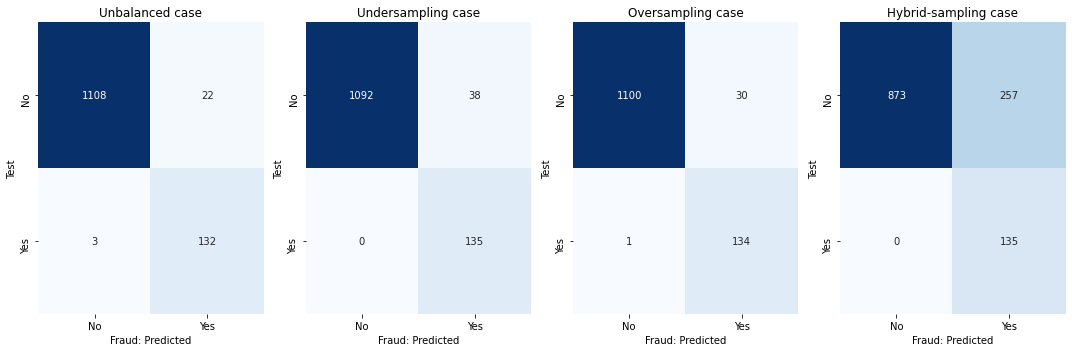

In [133]:
fig, ax = plt.subplots(1,4,figsize=(15,5))
labels=['No','Yes']

sns.heatmap(confusion_matrix(y_test, y_pred_1), annot=True, cmap="Blues", fmt='g', cbar=False,ax=ax[0])
ax[0].set_title('Unbalanced case')
ax[0].set_yticklabels(labels);
ax[0].set_xticklabels(labels);
ax[0].set_ylabel('Test')
ax[0].set_xlabel('Fraud: Predicted')

sns.heatmap(confusion_matrix(y_test, y_pred_2), annot=True, cmap="Blues", fmt='g', cbar=False,ax=ax[1])
ax[1].set_title('Undersampling case')
ax[1].set_yticklabels(labels);
ax[1].set_xticklabels(labels);
ax[1].set_ylabel('Test')
ax[1].set_xlabel('Fraud: Predicted')


sns.heatmap(confusion_matrix(y_test, y_pred_3), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[2])
ax[2].set_title('Oversampling case')
ax[2].set_xticklabels(labels);
ax[2].set_yticklabels(labels);
ax[2].set_ylabel('Test')
ax[2].set_xlabel('Fraud: Predicted')
plt.tight_layout()

sns.heatmap(confusion_matrix(y_test, y_pred_4), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[3])
ax[3].set_title('Hybrid-sampling case')
ax[3].set_xticklabels(labels);
ax[3].set_yticklabels(labels);
ax[3].set_ylabel('Test')
ax[3].set_xlabel('Fraud: Predicted')
plt.tight_layout()

plt.show()

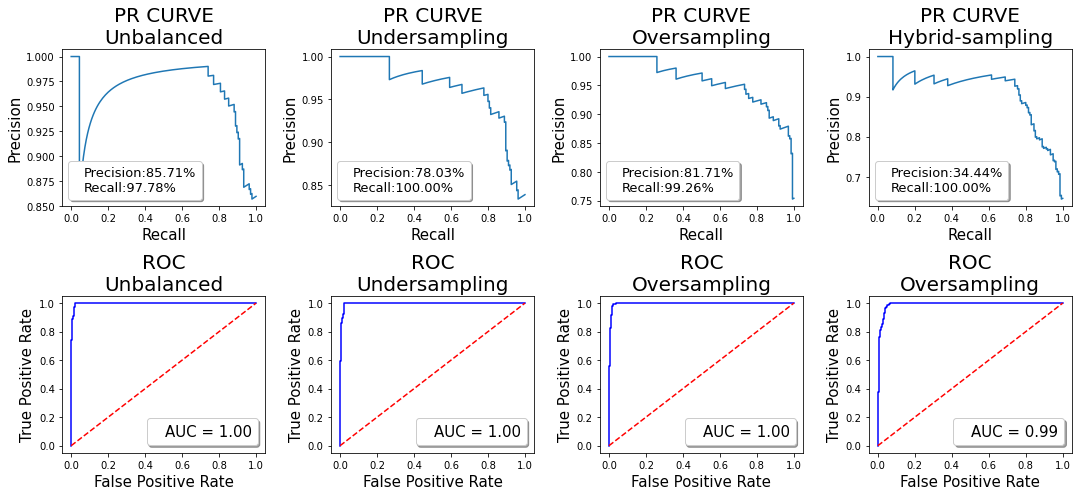

In [135]:
fig, ax = plt.subplots(2,4,figsize=(15,7))

####PR CURVES####

p,r,_ = precision_recall_curve(y_test,y_pred_prob_1)
ax[0,0].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_1)*100,recall_score(y_test, y_pred_1)*100))
ax[0,0].set_title('PR CURVE\nUnbalanced',fontsize=20)
ax[0,0].set_ylabel('Precision',fontsize=15)
ax[0,0].set_xlabel('Recall',fontsize=15)
ax[0,0].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

p,r,_ = precision_recall_curve(y_test,y_pred_prob_2)
ax[0,1].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_2)*100,recall_score(y_test, y_pred_2)*100))
ax[0,1].set_title('PR CURVE\nUndersampling',fontsize=20)
ax[0,1].set_ylabel('Precision',fontsize=15)
ax[0,1].set_xlabel('Recall',fontsize=15)
ax[0,1].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

p,r,_ = precision_recall_curve(y_test,y_pred_prob_3)
ax[0,2].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_3)*100,recall_score(y_test, y_pred_3)*100))
ax[0,2].set_title('PR CURVE\nOversampling',fontsize=20)
ax[0,2].set_ylabel('Precision',fontsize=15)
ax[0,2].set_xlabel('Recall',fontsize=15)
ax[0,2].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

p,r,_ = precision_recall_curve(y_test,y_pred_prob_4)
ax[0,3].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_4)*100,recall_score(y_test, y_pred_4)*100))
ax[0,3].set_title('PR CURVE\nHybrid-sampling',fontsize=20)
ax[0,3].set_ylabel('Precision',fontsize=15)
ax[0,3].set_xlabel('Recall',fontsize=15)
ax[0,3].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

####ROC####


fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_1)
roc_auccat = auc(fprcat, tprcat)
ax[1,0].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,0].plot([0, 1], [0, 1],'r--')
ax[1,0].set_title('ROC\nUnbalanced',fontsize=20)
ax[1,0].set_ylabel('True Positive Rate',fontsize=15)
ax[1,0].set_xlabel('False Positive Rate',fontsize=15)
ax[1,0].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)

fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_2)
roc_auccat = auc(fprcat, tprcat)
ax[1,1].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,1].plot([0, 1], [0, 1],'r--')
ax[1,1].set_title('ROC\nUndersampling',fontsize=20)
ax[1,1].set_ylabel('True Positive Rate',fontsize=15)
ax[1,1].set_xlabel('False Positive Rate',fontsize=15)
ax[1,1].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)


fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_3)
roc_auccat = auc(fprcat, tprcat)
ax[1,2].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,2].plot([0, 1], [0, 1],'r--')
ax[1,2].set_title('ROC\nOversampling',fontsize=20)
ax[1,2].set_ylabel('True Positive Rate',fontsize=15)
ax[1,2].set_xlabel('False Positive Rate',fontsize=15)
ax[1,2].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)

fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_4)
roc_auccat = auc(fprcat, tprcat)
ax[1,3].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,3].plot([0, 1], [0, 1],'r--')
ax[1,3].set_title('ROC\nOversampling',fontsize=20)
ax[1,3].set_ylabel('True Positive Rate',fontsize=15)
ax[1,3].set_xlabel('False Positive Rate',fontsize=15)
ax[1,3].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)

plt.tight_layout()
plt.show()

# Social Network Analysis

In [136]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

shill.head(10)

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7,0
5,8,900,i***e,0.038462,0.111111,0.0,0.016844,0.000000,0.000000,0.016844,0.800000,7,0
6,10,900,m***p,0.400000,0.222222,0.0,0.006781,0.000000,0.000000,0.006774,0.750000,7,0
7,12,900,k***a,0.137931,0.444444,1.0,0.768044,0.000000,0.000000,0.016311,1.000000,7,1
8,13,2370,g***r,0.121951,0.185185,1.0,0.035021,0.333333,0.993528,0.023963,0.944444,7,1
9,27,600,e***t,0.155172,0.346154,0.5,0.570994,0.307692,0.993593,0.413788,0.611111,7,1


In [137]:
G = nx.from_pandas_edgelist(shill, 'Auction_ID', 'Bidder_ID')

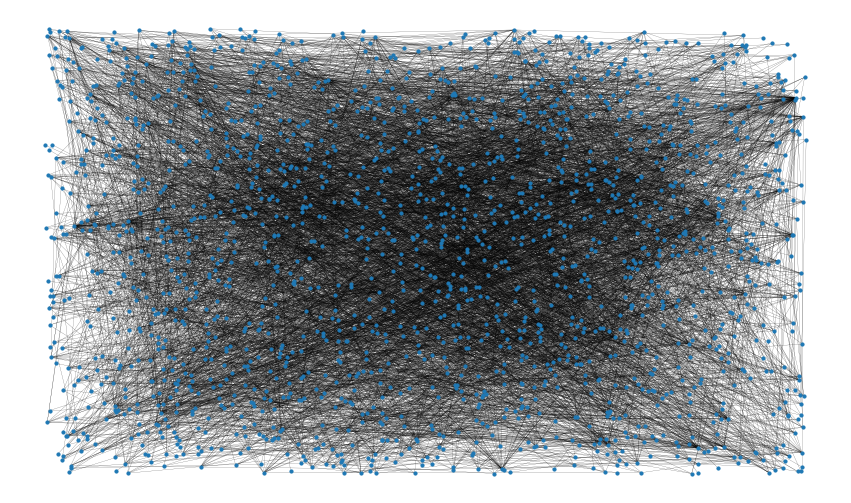

In [138]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis('off')
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

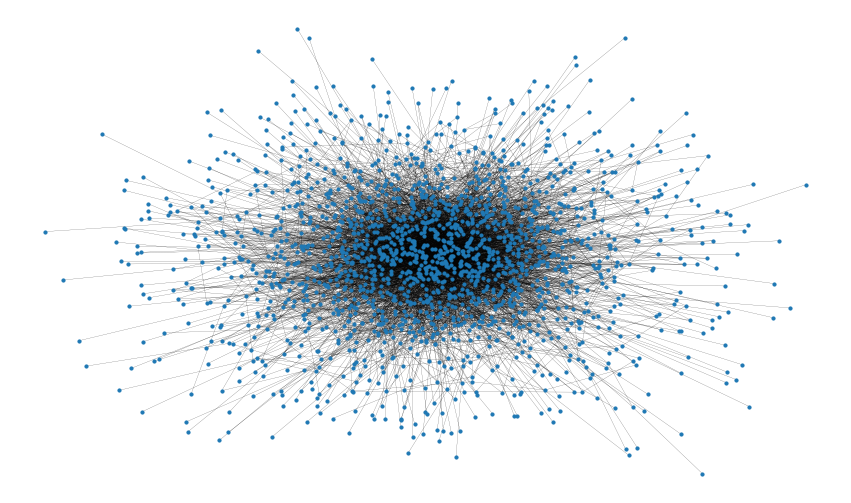

In [139]:
pos = nx.spring_layout(G, iterations=15, seed=42)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis('off')
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [140]:
G.number_of_nodes()

1861

In [141]:
G.number_of_edges()

6321

In [142]:
np.mean([d for _, d in G.degree()])


6.793121977431489

In [143]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [144]:
# This is equivalent to `diameter = nx.diameter(G), but much more efficient since we're
# reusing the pre-computed shortest path lengths!
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

8

In [145]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

4.131469188100092

Text(0, 0.5, 'Frequency (%)')

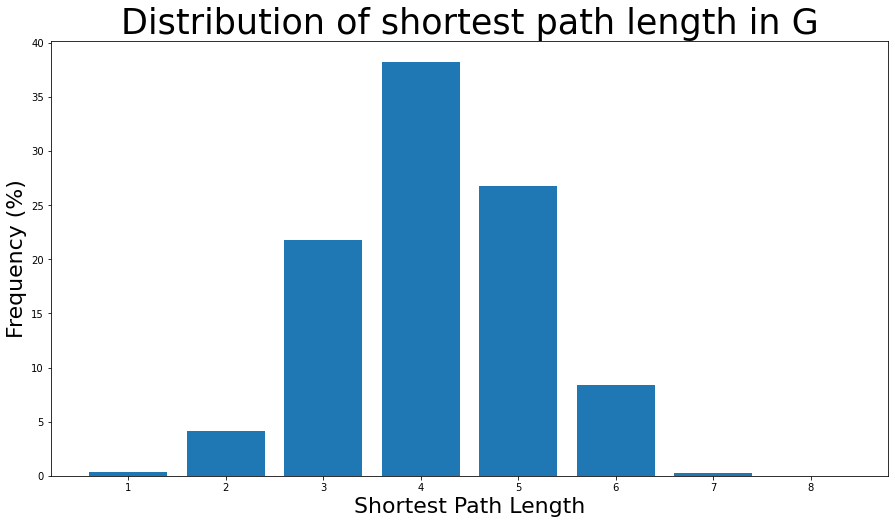

In [146]:
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    'Distribution of shortest path length in G', fontdict ={'size': 35}, loc='center'
)
ax.set_xlabel('Shortest Path Length', fontdict ={'size': 22})
ax.set_ylabel('Frequency (%)', fontdict ={'size': 22})

In [147]:
nx.density(G)


0.00365221611689865

In [148]:
nx.number_connected_components(G)


1

In [149]:
degree_centrality = nx.centrality.degree_centrality(G)  # save results in a variable to use again 
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('a***a', 0.06021505376344086),
 ('n***t', 0.0456989247311828),
 ('e***e', 0.03602150537634408),
 ('i***a', 0.026881720430107527),
 ('r***r', 0.026344086021505377),
 ('l***l', 0.025806451612903226),
 ('o***o', 0.024193548387096774),
 ('i***i', 0.023655913978494623)]

In [150]:
# the number of neighbors for the nodes with the highest degree centralities:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[('a***a', 112),
 ('n***t', 85),
 ('e***e', 67),
 ('i***a', 50),
 ('r***r', 49),
 ('l***l', 48),
 ('o***o', 45),
 ('i***i', 44)]

Text(0, 0.5, 'Counts')

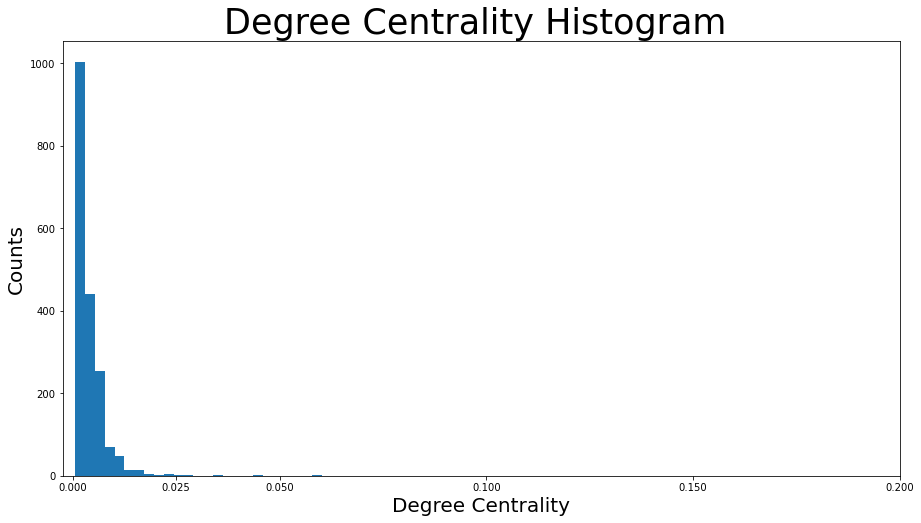

In [151]:
# the distribution of degree centralities will be plotted:

plt.figure(figsize=(15,8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title('Degree Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Degree Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

(-1.0778901666402816,
 1.048774668574333,
 -1.0427658796310424,
 1.0972745656967162)

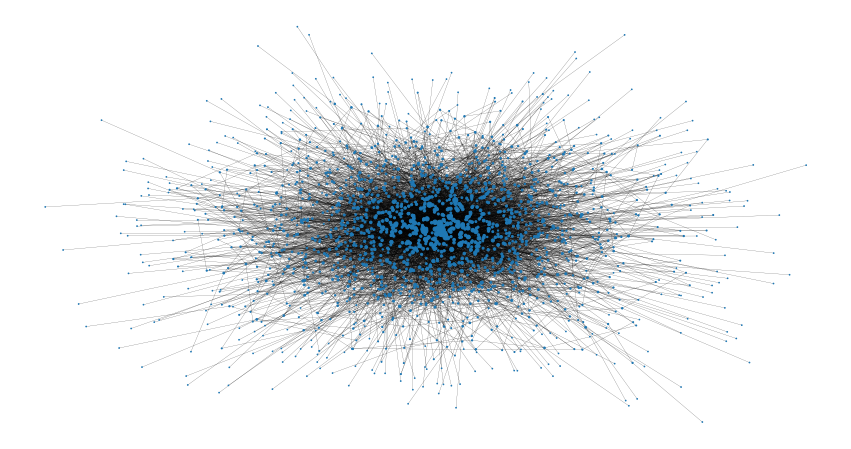

In [152]:
# check the users with highest degree centralities from the size of their nodes:

node_size =  [v * 1000 for v in degree_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')

In [153]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)  # save results in a variable to use again 
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('a***a', 0.11825877867629687),
 ('n***t', 0.0792290220209026),
 ('e***e', 0.052208901399505035),
 ('r***r', 0.03180683341369728),
 ('l***l', 0.028540196293610848),
 ('i***a', 0.027253114653085574),
 ('r***h', 0.02595792854767867),
 ('i***i', 0.02592329829179095)]

Text(0, 0.5, 'Counts')

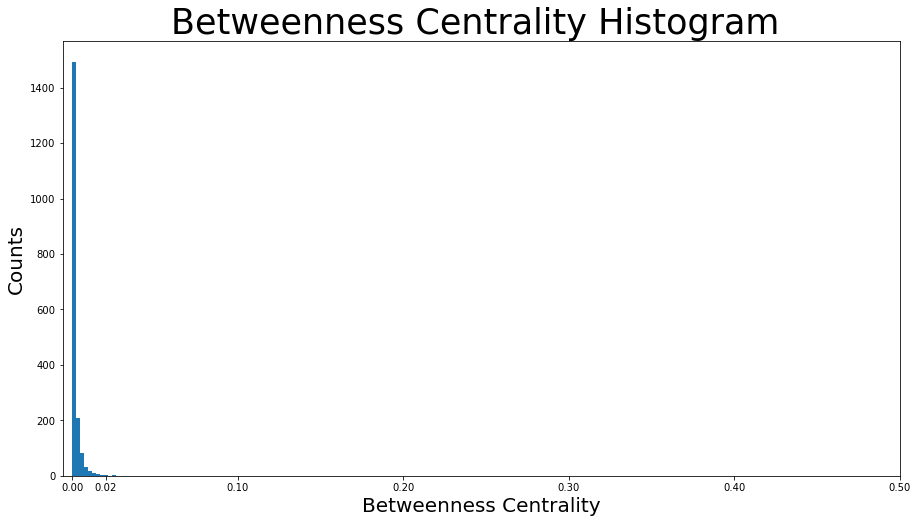

In [154]:
# the distribution of betweenness centralities will be plotted:

plt.figure(figsize=(15,8))
plt.hist(betweenness_centrality.values(), bins=50)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title('Betweenness Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Betweenness Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

(-1.0778901666402816,
 1.048774668574333,
 -1.0427658796310424,
 1.0972745656967162)

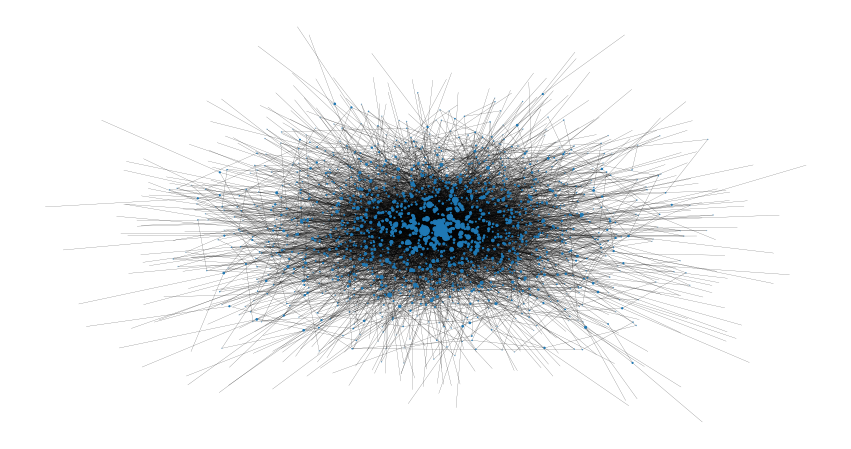

In [155]:
# We can also get an image on the nodes with the highest betweenness centralities and where they are located in the network. 
# It is clear that they are the bridges from one community to another:

node_size =  [v * 1200 for v in betweenness_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')

In [156]:
# The nodes with the highest closeness centralities will be found now:

closeness_centrality = nx.centrality.closeness_centrality(G)  # save results in a variable to use again 
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('a***a', 0.34311012728278917),
 ('n***t', 0.33567948023822414),
 ('e***e', 0.321410057024365),
 ('r***h', 0.3135007584695769),
 (1872, 0.3134479271991911),
 ('r***r', 0.3107769423558897),
 ('i***i', 0.31015507753876936),
 ('o***o', 0.30953569645531703)]

Text(0, 0.5, 'Counts')

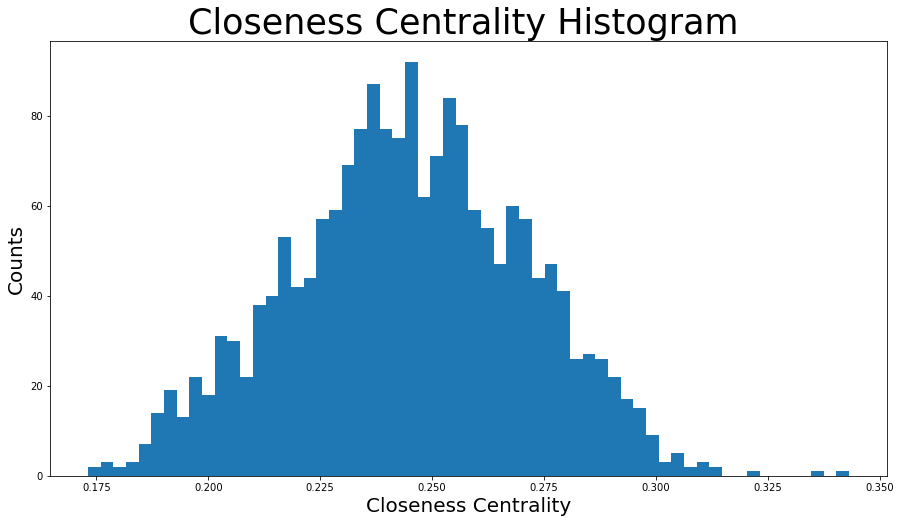

In [157]:
#the distribution of the closeness centralities:

plt.figure(figsize=(15,8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title('Closeness Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Closeness Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

(-1.0778901666402816,
 1.048774668574333,
 -1.0427658796310424,
 1.0972745656967162)

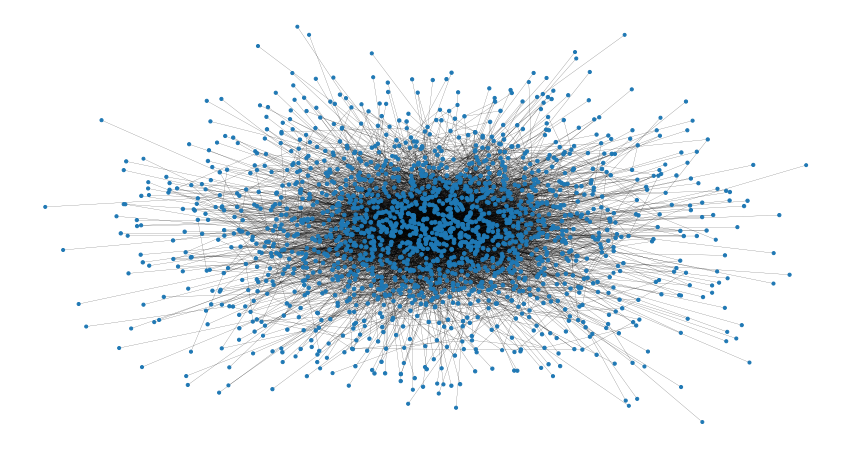

In [158]:
#there are some communities that are located further away, whose nodes would have the minimum closeness centralities, 
#as seen below:

node_size =  [v * 50 for v in closeness_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')